In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

2025-09-11 14:08:32.503295: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 14:08:32.566342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-11 14:08:34.018296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
def dropout_layer(x, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return tf.zeros_like(x)
    if dropout == 0:
        return x
    mask = tf.random.uniform(shape=tf.shape(x), minval=0.0, maxval=1.0) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * x / (1 - dropout)

In [3]:
x = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
print(dropout_layer(x, 0.8))

tf.Tensor(
[[ 0.  0.  0.  0.  0. 25. 30.  0.]
 [ 0.  0.  0.  0.  0.  0. 70.  0.]], shape=(2, 8), dtype=float32)


I0000 00:00:1757570915.009593 1482459 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30815 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0


In [4]:
num_hiddens1,num_hiddens2,num_output = 256,256,10
dropout1,dropout2 = 0.2,0.5

In [5]:
class NET(tf.keras.Model):
    def __init__(self, num_hiddens1, num_hiddens2, num_output):
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hiddens1 = tf.keras.layers.Dense(num_hiddens1, activation='relu')
        self.hiddens2 = tf.keras.layers.Dense(num_hiddens2, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_output)
    
    def call(self, inputs, training=None):
        x = self.input_layer(inputs)
        x = self.hiddens1(x)
        if training:
            x = dropout_layer(x, dropout1)
        x = self.hiddens2(x)
        if training:
            x = dropout_layer(x, dropout2)
        x = self.output_layer(x)
        return x

epoch:9, train_loss:0.297324, train_auc:0.887850


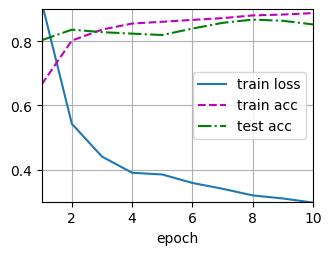

In [6]:
net = NET(num_hiddens1, num_hiddens2, num_output)
batch_size,lr,num_epochs = 256,0.5,10
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

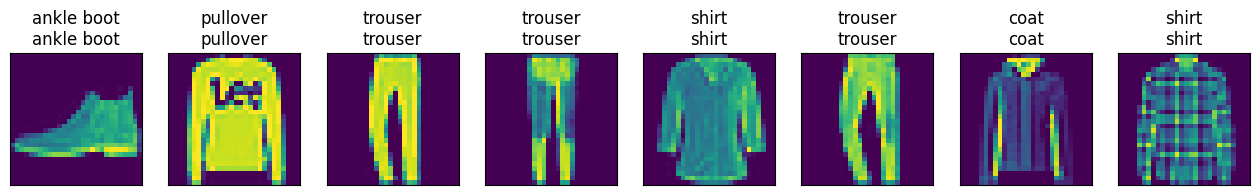

In [7]:
d2l.predict_ch3(net, test_iter)

epoch:9, train_loss:0.321090, train_auc:0.882750


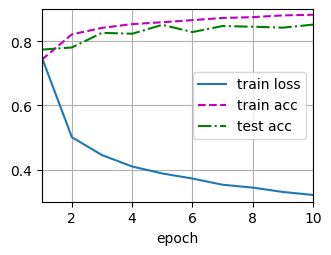

In [10]:
net = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(256, activation='relu'),
                                  tf.keras.layers.Dropout(dropout1),
                                  tf.keras.layers.Dense(256, activation='relu'),
                                  tf.keras.layers.Dropout(dropout2),
                                  tf.keras.layers.Dense(10)
                                  ])
optimizer = tf.keras.optimizers.SGD(0.1)
d2l.train_ch3(net,train_iter, test_iter, loss, num_epochs, optimizer)